In [98]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import uncertainties as u
import re

In [2]:
# Measurement Information

N_MEASUREMENTS = 100
N_POINTS = 5000000

In [3]:
# Obtain Files
# For 28/11 data, channel 1 and 2 show the same thing for each directory

calibrationDirectory = r"/users/laratatli/PycharmProjects/laser-spec/calibration_data_28_11/"
spectrumDirectory = r"/users/laratatli/PycharmProjects/laser-spec/spectrum_data_28_11/"

In [21]:
# Obtain spectrum scale values

with open(spectrumDirectory + "ch1_paramiters.txt", "r") as file:
    lines = file.readlines()
    
scale_factors_spectrum = {key: [] for key in ["XZERO", "XINCR", "YZERO", "YMULT"] }

for line in lines:
    for key in scale_factors_spectrum:
        match = re.search(rf"{key} ([\dE.+-]+)", line)
        if match:
            scale_factors_spectrum[key].append(float(match.group(1)))

#print("Scaling factors:", scale_factors) # use this to check scale factors are consistent across all runs

for key in scale_factors_spectrum:
    print(key, scale_factors_spectrum[key][0]) # return scale factors assuming the check above passes

XZERO -0.093
XINCR 4e-08
YZERO 0.065
YMULT 0.0008


In [22]:
# Obtain calibration scale values

with open(calibrationDirectory + "ch1_paramiters.txt", "r") as file:
    lines = file.readlines()
    print(lines)
    
scale_factors_calibration = {key: [] for key in ["XZERO", "XINCR", "YZERO", "YMULT"] }

for line in lines:
    for key in scale_factors_calibration:
        match = re.search(rf"{key} ([\dE.+-]+)", line)
        if match:
            scale_factors_calibration[key].append(float(match.group(1)))

#print("Scaling factors:", scale_factors) # use this to check scale factors are consistent across all runs

for key in scale_factors_calibration:
    print(key, scale_factors_calibration[key][0]) # return scale factors assuming the check above passes

[':WFMOUTPRE:BYT_NR 1;BIT_NR 8;ENCDG BINARY;BN_FMT RI;BYT_OR LSB;WFID "Ch1, DC coupling, 5.000mV/div, 20.00ms/div, 5000000 points, Sample mode";NR_PT 5000000;PT_FMT Y;PT_ORDER LINEAR;XUNIT "s";XINCR 40.0000E-9;XZERO -93.0000E-3;PT_OFF 0;YUNIT "V";YMULT 200.0000E-6;YOFF -103.5000;YZERO 0.0E+0;DOMAIN TIME;WFMTYPE ANALOG;CENTERFREQUENCY 0.0E+0;SPAN 0.0E+0;REFLEVEL 0.0E+0\n', ':WFMOUTPRE:BYT_NR 1;BIT_NR 8;ENCDG BINARY;BN_FMT RI;BYT_OR LSB;WFID "Ch1, DC coupling, 5.000mV/div, 20.00ms/div, 5000000 points, Sample mode";NR_PT 5000000;PT_FMT Y;PT_ORDER LINEAR;XUNIT "s";XINCR 40.0000E-9;XZERO -93.0000E-3;PT_OFF 0;YUNIT "V";YMULT 200.0000E-6;YOFF -103.5000;YZERO 0.0E+0;DOMAIN TIME;WFMTYPE ANALOG;CENTERFREQUENCY 0.0E+0;SPAN 0.0E+0;REFLEVEL 0.0E+0\n', ':WFMOUTPRE:BYT_NR 1;BIT_NR 8;ENCDG BINARY;BN_FMT RI;BYT_OR LSB;WFID "Ch1, DC coupling, 5.000mV/div, 20.00ms/div, 5000000 points, Sample mode";NR_PT 5000000;PT_FMT Y;PT_ORDER LINEAR;XUNIT "s";XINCR 40.0000E-9;XZERO -93.0000E-3;PT_OFF 0;YUNIT "V";YMULT

In [23]:
# Assign scale factor variables

SPECTRUM_XZERO= scale_factors_spectrum["XZERO"][0]
SPECTRUM_XINCR= scale_factors_spectrum["XINCR"][0]
SPECTRUM_YZERO= scale_factors_spectrum["YZERO"][0]
SPECTRUM_YMULT= scale_factors_spectrum["YMULT"][0]

CALIBRATION_XZERO= scale_factors_calibration["XZERO"][0]
CALIBRATION_XINCR= scale_factors_calibration["XINCR"][0]
CALIBRATION_YZERO= scale_factors_calibration["YZERO"][0]
CALIBRATION_YMULT= scale_factors_calibration["YMULT"][0]

print(SPECTRUM_XZERO)
print(SPECTRUM_XINCR)
print(SPECTRUM_YZERO)
print(SPECTRUM_YMULT)
print(CALIBRATION_XZERO)
print(CALIBRATION_XINCR)
print(CALIBRATION_YZERO)
print(CALIBRATION_YMULT)

-0.093
4e-08
0.065
0.0008
-0.093
4e-08
0.0
0.0002


In [75]:
# Calculate the mean and standard deviations of both data sets

#calculating means
mean_spectrum_unscaled = np.zeros(N_POINTS)
mean_calibration_unscaled = np.zeros(N_POINTS)

#sum values
for i in range(N_MEASUREMENTS):
    mean_spectrum_unscaled += np.fromfile(spectrumDirectory+"ch1_{}.bin".format(i), dtype='int8')
    mean_calibration_unscaled += np.fromfile(calibrationDirectory+"ch1_{}.bin".format(i), dtype='int8')

#divide by number of values to obtain mean
mean_spectrum_unscaled = mean_spectrum_unscaled/N_MEASUREMENTS
mean_calibration_unscaled = mean_calibration_unscaled/N_MEASUREMENTS

print(mean_spectrum_unscaled)
print(mean_calibration_unscaled)
print(len(mean_spectrum_unscaled))
print(len(mean_calibration_unscaled))

std_spectrum_unscaled = np.zeros(N_POINTS)
std_calibration_unscaled = np.zeros(N_POINTS)


#sum deviations squared
for i in range(N_MEASUREMENTS):
    std_spectrum_unscaled += (np.fromfile(spectrumDirectory+"ch1_{}.bin".format(i),dtype='int8')-mean_spectrum_unscaled)**2
    std_calibration_unscaled += (np.fromfile(calibrationDirectory+"ch1_{}.bin".format(i),dtype='int8')-mean_calibration_unscaled)**2

#divide by the degrees of freedom - obtains variance
std_spectrum_unscaled = std_spectrum_unscaled/(N_MEASUREMENTS-1)
std_calibration_unscaled = std_calibration_unscaled/(N_MEASUREMENTS-1)

# calculate square root
std_spectrum = np.sqrt(std_spectrum_unscaled)
std_calibration = np.sqrt(std_calibration_unscaled)

print("std spectrum =", std_spectrum)
print("std calibration =", std_calibration)


[-10.78 -10.49 -10.51 ...  -7.31  -7.58  -7.52]
[-0.96 -3.8  -1.34 ... -2.86 -1.94  0.57]
5000000
5000000
std spectrum = [3.12558681 2.90069654 2.86566226 ... 2.94630397 2.75306991 2.02748787]
std calibration = [9.68380925 8.79049073 7.90884941 ... 8.19092871 8.00734511 9.43264801]


In [76]:
#generate unscaled time data - we need to do this as oscilloscope itself doesn't

spectrum_time_unscaled = np.arange(0, N_POINTS)
calibration_time_unscaled = np.arange(0, N_POINTS)
spectrum_time_unscaled = np.arange(0, N_POINTS)
calibration_time_unscaled = np.arange(0, N_POINTS)

In [77]:
#scaling data (check programmer handbook for guide on this, essentially it's a linear transformation)

mean_spectrum = (SPECTRUM_YMULT * mean_spectrum_unscaled) + SPECTRUM_YZERO

mean_calibration = (CALIBRATION_YMULT * mean_calibration_unscaled) + CALIBRATION_YZERO

spectrum_time = (SPECTRUM_XINCR * spectrum_time_unscaled) + SPECTRUM_XZERO

calibration_time = (CALIBRATION_XINCR * calibration_time_unscaled) + CALIBRATION_XZERO

std_spectrum = (SPECTRUM_YMULT*std_spectrum_unscaled) + SPECTRUM_YZERO

std_calibration = (CALIBRATION_YMULT*std_calibration_unscaled) + CALIBRATION_YZERO

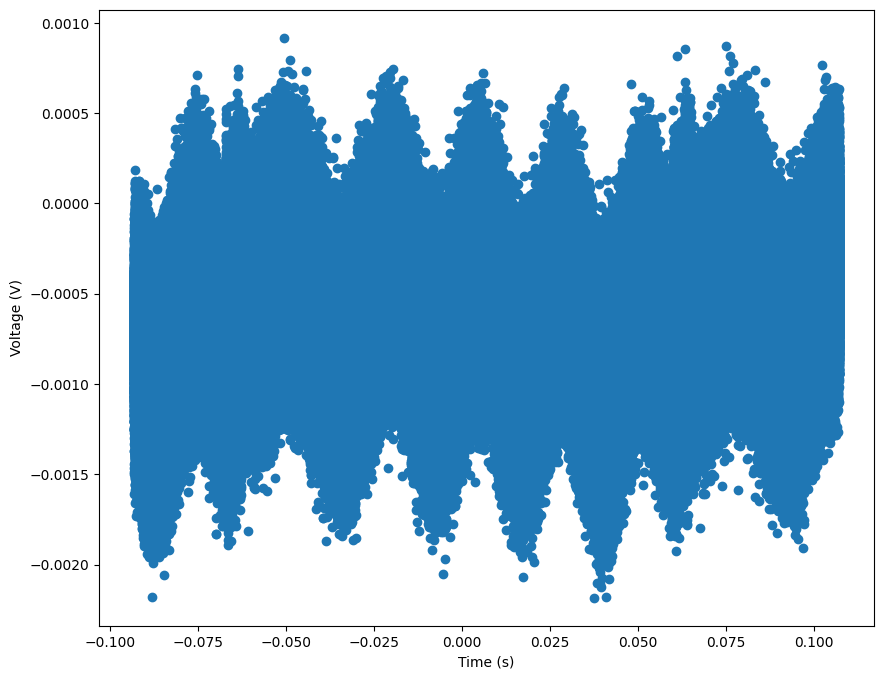

In [78]:
# Testing figures

plt.figure(figsize=(10,8))
#plt.plot(spectrum_time, mean_spectrum)
plt.scatter(calibration_time, mean_calibration)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()

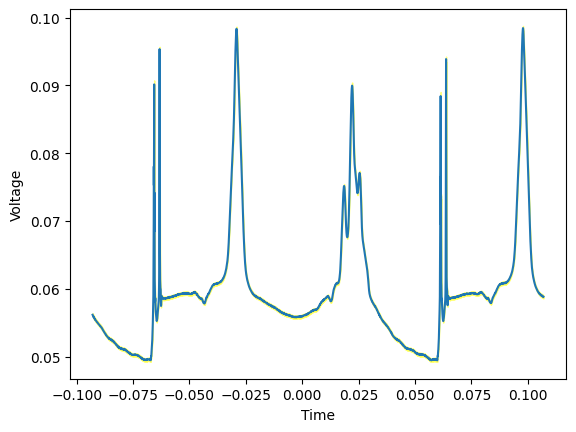

[0.05616157 0.05613307 0.0561276  ... 0.05883154 0.05883229 0.05881975]
5000
[0.00022625 0.00022606 0.00022614 ... 0.00022559 0.00022567 0.00022578]
5000


In [84]:
# TIME-AVERAGING THE SPECTRUM DATA

#work out averages by grouping

N_GROUPS = 5000
group_step = N_POINTS//N_GROUPS # calculating group sizes

if N_POINTS % N_GROUPS != 0:
    print("Warning: data points do not divide evenly into groups.")

mean_spectrum_time = np.zeros(N_GROUPS)
weighted_mean_spectrum = np.zeros(N_GROUPS)
err_mean_spectrum = np.zeros(N_GROUPS)

# weighted mean calculations: page 66 hughes & hase
w = 1 / (std_spectrum / np.sqrt(N_MEASUREMENTS - 1))**2
x = mean_spectrum

if np.any(std_spectrum == 0):
    raise ValueError("Standard deviation contains zero values, which would cause division by zero.")

for i in range(N_GROUPS):
    # start_idx = i * group_step
    # end_idx = min((i + 1) * group_step, N_POINTS)
    # mean_spectrum_time[i] = np.mean(spectrum_time[start_idx:end_idx]) # calculates average of spectrum_time for each group
    # weighted_mean_spectrum[i] = np.sum(x[start_idx:end_idx] * w[start_idx:end_idx]) / np.sum(w[start_idx:end_idx]) # weighted mean of the spectrum for each group
    # err_mean_spectrum[i] = np.sqrt(1 / np.sum(w[start_idx:end_idx])) # error in weighted mean
    mean_spectrum_time[i]=np.mean(np.array(spectrum_time[i*group_step:(i+1)*group_step]))
    weighted_mean_spectrum[i]=np.sum(x[i*group_step:(i+1)*group_step]*w[i*group_step:(i+1)*group_step])/np.sum(w[i*group_step:(i+1)*group_step])
    err_mean_spectrum[i]=np.sqrt(1/np.sum(w[i*group_step:(i+1)*group_step]))


plt.plot(mean_spectrum_time, weighted_mean_spectrum)
#plt.errorbar(mean_spectrum_time, weighted_mean_spectrum, yerr=abs(weighted_mean_spectrum/np.sqrt(N_GROUPS-1)), capsize=3)
plt.fill_between(
    x=mean_spectrum_time,
    y1=weighted_mean_spectrum + err_mean_spectrum,
    y2=weighted_mean_spectrum - err_mean_spectrum,
    alpha=0.5,
    color='yellow'
)

plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

print(weighted_mean_spectrum)
print(len(weighted_mean_spectrum))
print(err_mean_spectrum)
print(len(err_mean_spectrum))

In [112]:
# Truncate data

weighted_mean_spectrum = weighted_mean_spectrum[1000:3700]
err_mean_spectrum = err_mean_spectrum[1000:3700]
mean_spectrum_time = mean_spectrum_time[1000:3700]

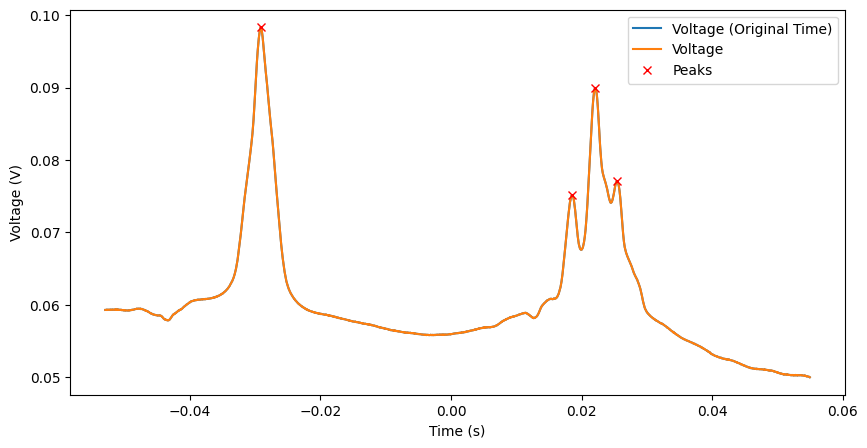

Spectrum Peaks:
Peak 1: Time = -0.02914002, Value = 0.059292076397265366
Peak 2: Time = 0.018579980000000003, Value = 0.059297906006986006
Peak 3: Time = 0.02209998, Value = 0.05929726989122976
Peak 4: Time = 0.025419980000000002, Value = 0.05929323600215655


In [115]:
# Plot peaks

from scipy.signal import find_peaks

# Identify peaks in the spectrum data
spectrum_peaks, _ = find_peaks(weighted_mean_spectrum, height=0.07, distance=50)  # Adjust height and distance as needed

# Extract peak times
spectrum_peak_times = mean_spectrum_time[spectrum_peaks]

# Plot spectrum with frequency on the x-axis
plt.figure(figsize=(10, 5))
plt.plot(mean_spectrum_time, weighted_mean_spectrum, label="Voltage (Original Time)")

plt.plot(mean_spectrum_time, weighted_mean_spectrum, label="Voltage")
plt.plot(mean_spectrum_time[spectrum_peaks], weighted_mean_spectrum[spectrum_peaks], "rx", label="Peaks")  
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()
plt.show()

print("Spectrum Peaks:")
for i, t in enumerate(mean_spectrum_time[spectrum_peaks]):
    print(f"Peak {i + 1}: Time = {t}, Value = {weighted_mean_spectrum[i]}")


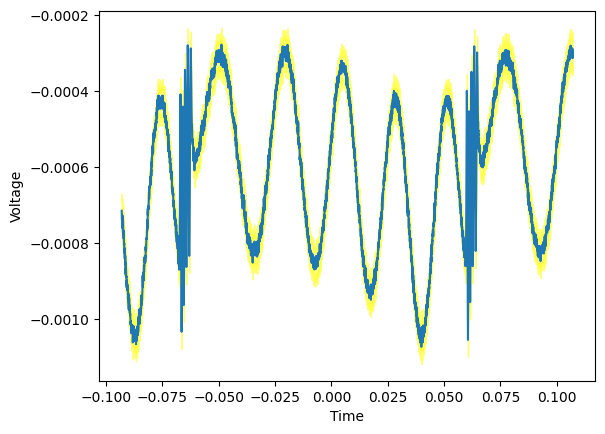

[281442.90072556 414498.26989619 632589.49831329 ... 549847.9612123
 602033.99615213 312637.22631163]
[4.48352891e-05 4.44827222e-05 4.42457202e-05 ... 4.38302692e-05
 4.40808751e-05 4.39535166e-05]
5000


In [117]:
# TIME-AVERAGING THE CALIBRATION DATA

#work out averages by grouping

N_GROUPS = 5000
group_step = N_POINTS//N_GROUPS # calculating group sizes

if N_POINTS % N_GROUPS != 0:
    print("Warning: data points do not divide evenly into groups.")

mean_calibration_time = np.zeros(N_GROUPS)
weighted_mean_calibration = np.zeros(N_GROUPS)
err_mean_calibration= np.zeros(N_GROUPS)

# weighted mean calculations: page 66 hughes & hase
w = 1 / (std_calibration / np.sqrt(N_MEASUREMENTS - 1))**2
x = mean_calibration

if np.any(std_calibration == 0):
    raise ValueError("Standard deviation contains zero values, which would cause division by zero.")

for i in range(N_GROUPS):
    # start_idx = i * group_step
    # end_idx = min((i + 1) * group_step, N_POINTS)
    # mean_spectrum_time[i] = np.mean(spectrum_time[start_idx:end_idx]) # calculates average of spectrum_time for each group
    # weighted_mean_spectrum[i] = np.sum(x[start_idx:end_idx] * w[start_idx:end_idx]) / np.sum(w[start_idx:end_idx]) # weighted mean of the spectrum for each group

    mean_calibration_time[i] = np.mean(np.array(calibration_time[i*group_step : (i+1)*group_step]))
    weighted_mean_calibration[i] = np.sum(x[i*group_step:(i+1)*group_step]*w[i*group_step:(i+1)*group_step])/np.sum(w[i*group_step:(i+1)*group_step])
    err_mean_calibration[i] = np.sqrt(1/np.sum(w[i*group_step:(i+1)*group_step]))


plt.plot(mean_calibration_time, weighted_mean_calibration)
#plt.errorbar(mean_calibration_time, weighted_mean_calibration, yerr=abs(weighted_mean_calibration/np.sqrt(N_GROUPS-1)), capsize=3)
plt.fill_between(
    x=mean_calibration_time,
    y1=weighted_mean_calibration + err_mean_calibration,
    y2=weighted_mean_calibration - err_mean_calibration,
    alpha=0.5,
    color='yellow'
)

plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

print(w)
print(err_mean_calibration)
print(len(err_mean_calibration))

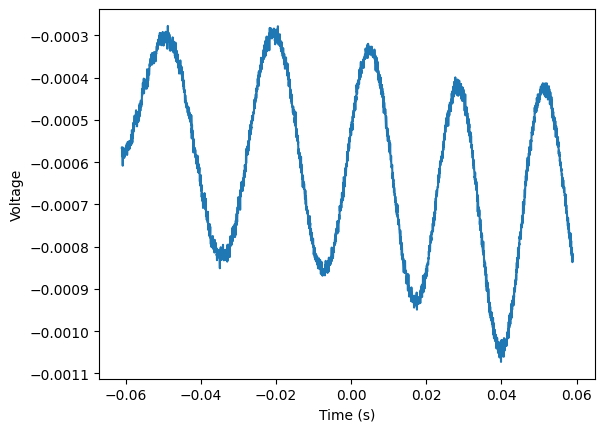

In [132]:
# non-uniform spacings between peaks, so relationship between time and frequency is non-linear. hence will use scipy.optimize to fit the data to a theoretical model

ct = mean_calibration_time[800:3800]
cv = weighted_mean_calibration[800:3800]
ce = err_mean_calibration[800:3800]

plt.plot(ct,cv)

plt.xlabel("Time (s)")
plt.ylabel("Voltage")
plt.show()

In [158]:
def calibration_fit(t, *params):
    return (params[0]*t**2 + params[1]*t + params[2])*(np.sin(params[3]*t**2 + params[4]*t + params[5]) + (params[6]*t**2 + params[7]*t + params[8]))
    # (A2*t**2 + A1*t + A0)*(np.sin(B2*t**2 + B1*t + B0)) + (C2*t**2 + C1*t + C0)


x_values = ct 
y_values = cv
y_errors = ce

# Initial guesses 
#p0 = [0.0004, 0.0002, 0.0004, 5, 262, 0, 0, 0, -0.0007] # (A2*t**2 + A1*t + A0)*(np.sin(B2*t**2 + B1*t + B0)) + (C2*t**2 + C1*t + C0)

# force any parameter with an initial value of zero to remain zero
def constrained_calibration_fit(t, *params):
    constrained_params = [
        params[i] if p0[i] != 0 else 0 for i in range(len(params))
    ]
    return calibration_fit(t, *constrained_params)

# Fit using curve_fit
popt, pcov = scipy.optimize.curve_fit(
    f=constrained_calibration_fit,
    xdata=x_values,
    ydata=y_values,
    p0=p0,
    sigma=y_errors,
    absolute_sigma=True
)

# Normalised residuals

residuals = y_values - calibration_fit(x_values, *popt)
normalised_residuals= residuals / np.std(residuals)


# Chi-squared calculation
def chi_squared(model_params, model, x_data, y_data, y_err):
    return np.sum(((y_data - model(x_data, *model_params))/y_err)**2)

# obtain optimal parameters
def print_optimization_results(model_name, popt, cov, model, x_values, y_values, y_errors):
    chi_squared_min = chi_squared(popt, model, x_values, y_values, y_errors)
    degrees_of_freedom = len(x_values) - len(popt)

    print(f'{model_name} Model:')
    print('chi^2_min = {}'.format(chi_squared_min))
    print('reduced chi^2 = {}'.format(chi_squared_min / degrees_of_freedom))
    print('P(chi^2_min, DoF) = {}'.format(scipy.stats.chi2.sf(chi_squared_min, degrees_of_freedom)))

    popt_errs = np.sqrt(np.diag(cov))
    for i, (val, err) in enumerate(zip(popt, popt_errs)):
        print(f'Optimized parameter[{i}] = {val:.4e} +/- {err:.4e} units')
    print('\n') 
    
print_optimization_results('Calibration Fit', popt, pcov, calibration_fit, x_values, y_values, y_errors)

Calibration Fit Model:
chi^2_min = 4310.197220028816
reduced chi^2 = 1.4410555733964616
P(chi^2_min, DoF) = 1.636308670333396e-51
Optimized parameter[0] = -1.1237e-05 +/- inf units
Optimized parameter[1] = 7.8900e-04 +/- inf units
Optimized parameter[2] = 2.6539e-04 +/- inf units
Optimized parameter[3] = 5.4389e+02 +/- inf units
Optimized parameter[4] = 2.4888e+02 +/- inf units
Optimized parameter[5] = 0.0000e+00 +/- inf units
Optimized parameter[6] = 0.0000e+00 +/- inf units
Optimized parameter[7] = 0.0000e+00 +/- inf units
Optimized parameter[8] = -2.3434e+00 +/- inf units




/var/folders/wx/c342xfyn5d79yh5st5d07n0w0000gn/T/ipykernel_33633/118825772.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(


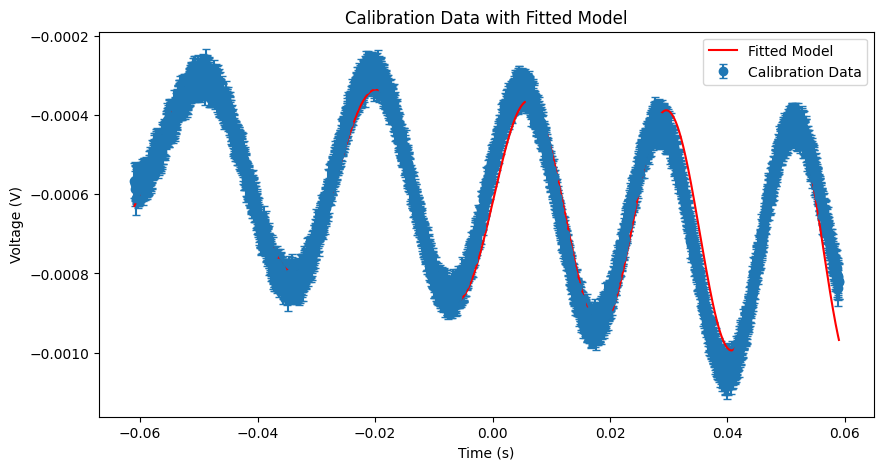

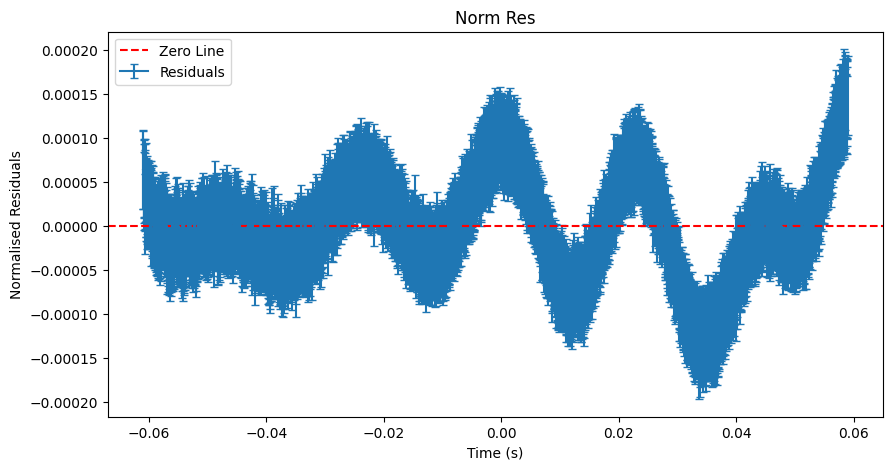

In [159]:
import matplotlib.pyplot as plt

# Plot the calibration data and the fitted model
plt.figure(figsize=(10, 5))
plt.errorbar(x_values, y_values, yerr=y_errors, fmt='o', label='Calibration Data', capsize=3)
plt.plot(x_values, calibration_fit(x_values, *popt), label='Fitted Model', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Calibration Data with Fitted Model')
plt.legend()
plt.show()

# Plot residuals
plt.figure(figsize=(10, 5))
plt.errorbar(x_values, residuals, yerr=y_errors, label='Residuals', capsize=3)
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Time (s)')
plt.ylabel('Normalised Residuals')
plt.title('Norm Res')
plt.legend()
plt.show()


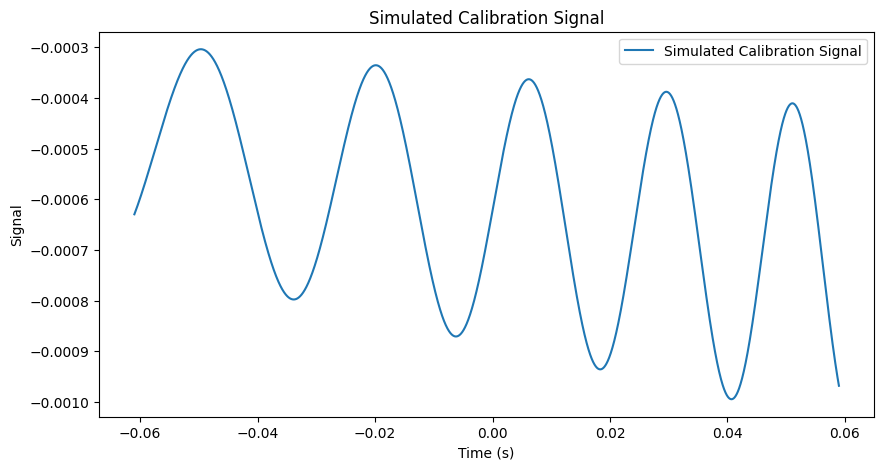

Detected peak times (s): [-0.04967753 -0.0198735   0.00616302  0.0295839   0.05106104]
Time intervals between fringes (s): [0.02980402 0.02603653 0.02342088 0.02147714]


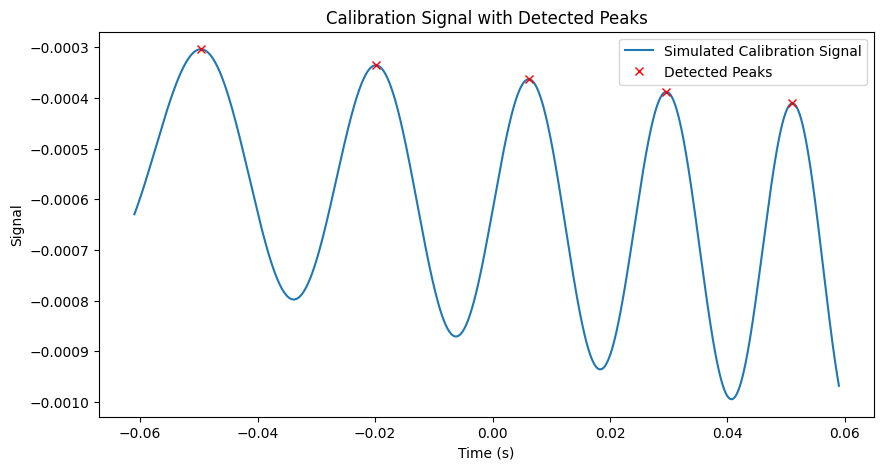

In [161]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# Generate the calibration signal
calibration_times = np.linspace(min(ct), max(ct), 5000)  # Higher resolution
calibration_signal = calibration_fit(calibration_times, *popt)  # Simulate signal

# Visualize the simulated signal
plt.figure(figsize=(10, 5))
plt.plot(calibration_times, calibration_signal, label="Simulated Calibration Signal")
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("Simulated Calibration Signal")
plt.legend()
plt.show()

# Adjust prominence or other parameters for peak detection
calibration_peaks, _ = find_peaks(calibration_signal, prominence=-0.005)  # Relaxed prominence
if len(calibration_peaks) == 0:
    print("No peaks detected! Check prominence or signal resolution.")
else:
    # Extract times of detected peaks
    calibration_peak_times = calibration_times[calibration_peaks]

    # Print detected peaks
    print("Detected peak times (s):", calibration_peak_times)

    # Calculate time intervals between peaks
    time_intervals = np.diff(calibration_peak_times)
    print("Time intervals between fringes (s):", time_intervals)

    # Plot peaks on the signal
    plt.figure(figsize=(10, 5))
    plt.plot(calibration_times, calibration_signal, label="Simulated Calibration Signal")
    plt.plot(calibration_peak_times, calibration_signal[calibration_peaks], "rx", label="Detected Peaks")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal")
    plt.title("Calibration Signal with Detected Peaks")
    plt.legend()
    plt.show()


In [192]:
# From the above we can see that the B2 value of the model is not 0 otherwise the frequency spacing would be even and the time intervals would be the same. So we can calculate an experimental value for our sweep rate and compare it to the theoretical

from scipy.constants import c

def sweep_rate(t, B2, B1):
    return (2 * B2 * t + B1) * (c/(4*np.pi*0.3)) # converts it to Hz

# Extract phase coefficients from fitted parameters
B2 = popt[3]  
B1 = popt[4]  

print(B2)
print(B1)

# Calculate experimental sweep rates at detected peak times
experimental_sweep_rates = sweep_rate(calibration_peak_times, B2, B1)
print("Experimental Sweep Rates at Peaks (Hz/s):", experimental_sweep_rates)

# Average experimental sweep rate
average_experimental_sweep_rate = np.mean(experimental_sweep_rates)
print(f"Average Experimental Sweep Rate: {average_experimental_sweep_rate:.6e} Hz/s")

# Don't forget to calculate standard error


543.891097292135
248.8846706937504
Experimental Sweep Rates at Peaks (Hz/s): [1.54946524e+10 1.80727921e+10 2.03250317e+10 2.23510094e+10
 2.42088476e+10]
Average Experimental Sweep Rate: 2.009047e+10 Hz/s


In [193]:
# Interferometer path length difference
delta_L = 0.30  

# Theoretical Hz/fringe
hz_per_fringe_theoretical = c / (2 * delta_L)
print(f"Theoretical Hz/Fringe: {hz_per_fringe_theoretical:.6e} Hz/fringe")

# Experimental average time interval from detected fringes
average_time_interval = np.mean(time_intervals)
std_time_interval = np.std(time_intervals)

# Theoretical sweep rate 
sweep_rate_theoretical = hz_per_fringe_theoretical / average_time_interval
print(f"Theoretical Sweep Rate: {sweep_rate_theoretical:.6e} Hz/s")

Theoretical Hz/Fringe: 4.996541e+08 Hz/fringe
Theoretical Sweep Rate: 1.983964e+10 Hz/s


In [194]:
# Compare sweep rates
difference = average_experimental_sweep_rate - sweep_rate_theoretical
percent_difference = (difference / sweep_rate_theoretical) * 100

print(f"Difference: {difference:.6e} Hz/s")
print(f"Percentage Difference: {percent_difference:.2f}%")


Difference: 2.508311e+08 Hz/s
Percentage Difference: 1.26%


In [ ]:
# Ok so there seems to be a huge mismatch between the theoretical sweep value and the experimental one and im not sure why. but for now i will have to use the theoretical value i guess.
# Consider going back and refitting the model 
# or plan b: use sweep rate method (think this worked?!)

In [204]:
# Convert spectrum time to frequency
spectrum_frequency = mean_spectrum_time * average_experimental_sweep_rate
print("Spectrum Frequency (Hz):", spectrum_frequency)


Spectrum Frequency (Hz): [-1.06439333e+09 -1.06358971e+09 -1.06278609e+09 ...  1.10296622e+09
  1.10376984e+09  1.10457346e+09]


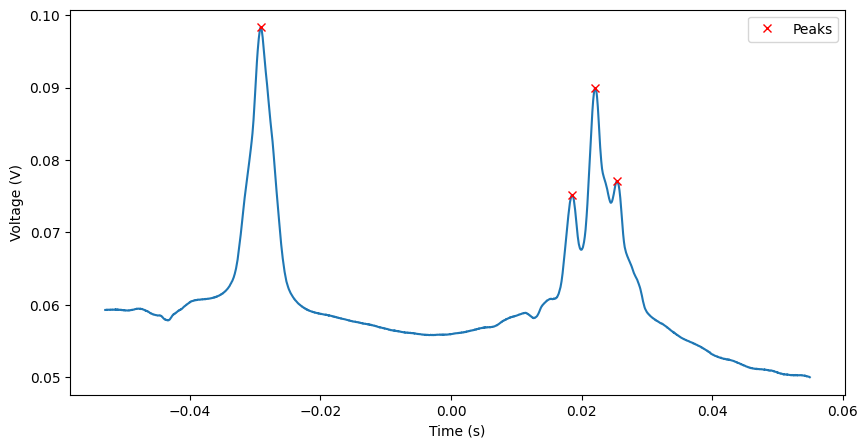

Spectrum Peaks:
Peak 1: Time = -0.02914002
Peak 2: Time = 0.018579980000000003
Peak 3: Time = 0.02209998
Peak 4: Time = 0.025419980000000002


In [206]:
# Prior to scaling time axis

from scipy.signal import find_peaks

# Identify peaks in the spectrum data
spectrum_peaks, _ = find_peaks(weighted_mean_spectrum, height=0.07, distance=50)  # Adjust height and distance as needed

# Extract peak times
spectrum_peak_times = mean_spectrum_time[spectrum_peaks]

# Plot spectrum with frequency on the x-axis
plt.figure(figsize=(10, 5))

plt.plot(mean_spectrum_time, weighted_mean_spectrum)
plt.plot(mean_spectrum_time[spectrum_peaks], weighted_mean_spectrum[spectrum_peaks], "rx", label="Peaks")  
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.legend()
plt.show()

print("Spectrum Peaks:")
for i, t in enumerate(mean_spectrum_time[spectrum_peaks]):
    print(f"Peak {i + 1}: Time = {t}")


In [200]:
# Choose a reference peak for zero detuning (e.g., the first detected peak)
reference_peak_index = 0 
reference_frequency = spectrum_frequency[spectrum_peaks[reference_peak_index]]

# Apply detuning
detuned_frequency = spectrum_frequency - reference_frequency


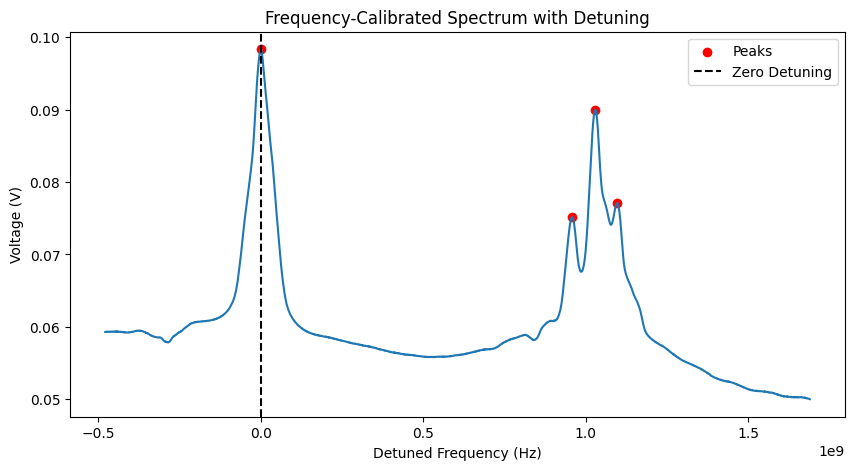

In [207]:
# Plot spectrum with detuned frequency axis
plt.figure(figsize=(10, 5))
plt.plot(detuned_frequency, weighted_mean_spectrum)
plt.scatter(detuned_frequency[spectrum_peaks], weighted_mean_spectrum[spectrum_peaks], color='red', label="Peaks")
plt.axvline(0, color='black', linestyle='--', label="Zero Detuning") 
plt.xlabel("Detuned Frequency (Hz)")
plt.ylabel("Voltage (V)")
plt.title("Frequency-Calibrated Spectrum with Detuning")
plt.legend()
plt.show()


In [210]:
print("Spectrum Peaks (Detuned Frequencies):")
for i, peak_index in enumerate(spectrum_peaks):
    print(f"Peak {i + 1}: Frequency = {detuned_frequency[peak_index]:.6e} Hz, Voltage = {weighted_mean_spectrum[peak_index]:.2f}")


Spectrum Peaks (Detuned Frequencies):
Peak 1: Frequency = 0.000000e+00 Hz, Voltage = 0.10
Peak 2: Frequency = 9.587171e+08 Hz, Voltage = 0.08
Peak 3: Frequency = 1.029436e+09 Hz, Voltage = 0.09
Peak 4: Frequency = 1.096136e+09 Hz, Voltage = 0.08
